In [1]:
import os
import sys
import time
import math

import dill
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from src import utils
from src import bilstm
import src.dataset as dset
import src.pytorch_utils as ptu
import src.chu_liu_edmonds as chu

import warnings
warnings.filterwarnings('ignore')

seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(seed)

device = torch.device("cpu")
print(device)
versions_dir = 'models'

cpu


In [2]:
train_dataset = dset.DataSet('data/train.labeled', tqdm_bar=True, use_glove=False)
test_dataset = dset.DataSet('data/test.labeled', train_dataset=train_dataset, tqdm_bar=True, use_glove=False)
comp_dataset = dset.DataSet('data/comp.unlabeled', train_dataset=train_dataset, tagged=False, tqdm_bar=True, use_glove=False)

100%|██████████| 24744/24744 [00:03<00:00, 7662.24it/s]


In [3]:
version = 'V1_1.1'
checkpoint = ptu.load_model(version=version, versions_dir=versions_dir, epoch='best', seed=42)
display(checkpoint.model)
display(checkpoint.log)

model version: V1_1.1
Number of parameters 5130001 trainable 5130001
epochs: 31
train_time: 39.941

last train_loss: 0.00046
last val_loss: 0.87446
last train_score: 0.99988
last val_score: 0.89283
best val_score: 0.89283 at epoch 31


BiLSTM(
  (word_embedding_layer): Embedding(14165, 300, padding_idx=0)
  (tag_embedding_layer): Embedding(48, 25, padding_idx=0)
  (lstm): LSTM(325, 125, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (attention): AdditiveAttention(
    (mlp1): Linear(in_features=250, out_features=100, bias=True)
    (mlp2): Linear(in_features=250, out_features=100, bias=True)
    (activation): Tanh()
    (out): Linear(in_features=100, out_features=1, bias=True)
  )
  (softmax): LogSoftmax()
)

,train_time,timestamp,train_loss,val_loss,train_score,val_score,batch_size,best,amsgrad,betas,eps,lr,weight_decay
1,1.230156,13:53:51 28-06-2020,0.464093,0.525441,0.863780,0.843535,8,True,False,"(0.9, 0.999)",1.000000e-08,0.002000,5.000000e-07
2,2.603845,13:55:14 28-06-2020,0.300179,0.462614,0.905530,0.855622,8,True,False,"(0.9, 0.999)",1.000000e-08,0.002000,5.000000e-07
3,3.898828,13:56:31 28-06-2020,0.206459,0.470122,0.931579,0.861583,8,True,False,"(0.9, 0.999)",1.000000e-08,0.002000,5.000000e-07
4,5.233029,13:57:52 28-06-2020,0.151344,0.485553,0.951482,0.867091,8,True,False,"(0.9, 0.999)",1.000000e-08,0.002000,5.000000e-07
5,6.526466,13:59:09 28-06-2020,0.124559,0.512933,0.964668,0.874203,8,True,False,"(0.9, 0.999)",1.000000e-08,0.002000,5.000000e-07
6,7.937158,14:00:34 28-06-2020,0.087245,0.523487,0.972582,0.874902,8,True,False,"(0.9, 0.999)",1.000000e-08,0.002000,5.000000e-07
7,9.216270,14:01:51 28-06-2020,0.076479,0.560943,0.974998,0.873751,8,False,False,"(0.9, 0.999)",1.000000e-08,0.002000,5.000000e-07
8,10.447215,14:03:04 28-06-2020,0.057015,0.583519,0.981782,0.876012,8,True,False,"(0.9, 0.999)",1.000000e-08,0.002000,5.000000e-07
9,11.877839,14:04:30 28-06-2020,0.051447,0.647543,0.983243,0.880041,8,True,False,"(0.9, 0.999)",1.000000e-08,0.002000,5.000000e-07
10,13.147778,14:05:46 28-06-2020,0.046314,0.632448,0.985220,0.879260,8,False,False,"(0.9, 0.999)",1.000000e-08,0.002000,5.000000e-07


In [4]:
%%time
test_loss, test_score, test_y_pred, test_y_true = checkpoint.predict(test_dataset.dataset(train=False),
                                                                     batch_size=32,
                                                                     device=device,
                                                                     results=True,
                                                                     decision_func=chu.test_chu_liu_edmonds)
print(f'chu_liu_edmonds_UAS: {test_score}')

chu_liu_edmonds_UAS: 0.8928263103802672
CPU times: user 39.6 s, sys: 6.06 s, total: 45.6 s
Wall time: 16.4 s


In [5]:
test_dataset.insert_predictions(preds=test_y_pred, name='test_m1')

In [6]:
%%time
comp_loss, comp_score, comp_y_pred, comp_y_true = checkpoint.predict(comp_dataset.dataset(train=False),
                                                                     batch_size=32,
                                                                     device=device,
                                                                     results=True,
                                                                     decision_func=chu.test_chu_liu_edmonds)
print(f'chu_liu_edmonds_UAS: {comp_score}')

chu_liu_edmonds_UAS: 0.0429161051212938
CPU times: user 39.8 s, sys: 4.74 s, total: 44.5 s
Wall time: 14 s


In [7]:
comp_dataset.insert_predictions(preds=comp_y_pred, name='comp_m1')

In [8]:
# checkpoint.save(best=True)

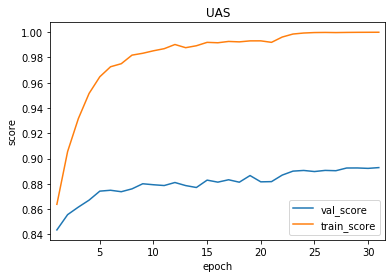

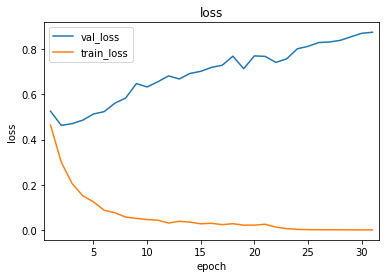

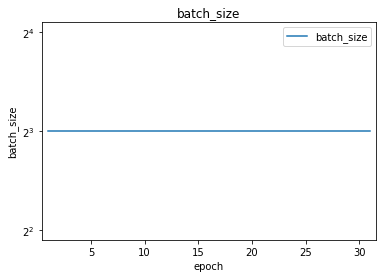

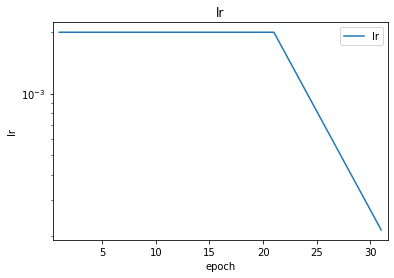

In [9]:
plt_save = True
checkpoint.plot_checkpoint(['val_score', 'train_score'], plot_title='UAS', y_label='score', scale='linear', basey=10, save=plt_save)
checkpoint.plot_checkpoint(['val_loss', 'train_loss'], plot_title='loss', y_label='loss', scale='linear', basey=10, save=plt_save)
checkpoint.plot_checkpoint(['batch_size'], plot_title='batch_size', y_label='batch_size', scale='log', basey=2, save=plt_save)
checkpoint.plot_checkpoint(['lr'], plot_title='lr', y_label='lr', scale='log', basey=10, save=plt_save)

In [10]:
checkpoint.log.tail(1)

,train_time,timestamp,train_loss,val_loss,train_score,val_score,batch_size,best,amsgrad,betas,eps,lr,weight_decay
31,39.941486,14:32:37 28-06-2020,0.00046,0.874457,0.999884,0.892826,8,True,False,"(0.9, 0.999)",1.000000e-08,0.000215,0.000001


In [11]:
torch.save(checkpoint.model, 'model_m1_final.pth')